In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns',None)
sns.set_theme()

In [2]:
df = pd.read_csv('final_dataset.csv')

In [3]:
import pandas as pd
import numpy as np # Ensure numpy is imported for numerical operations
import matplotlib.pyplot as plt # For plotting
import seaborn as sns # For plotting style

# Assume 'df' is your current DataFrame as per the latest info() output

# --- Step 1: Convert 'date' column to DatetimeIndex ---
print("--- DataFrame Info BEFORE setting DatetimeIndex ---")
print(df.info())

df['date'] = pd.to_datetime(df['date']) # Convert the 'date' column to datetime objects
df = df.set_index('date').sort_index() # Set 'date' as index and sort it chronologically

print("\n--- DataFrame Info AFTER setting DatetimeIndex ---")
print(df.info())
print("\n--- DataFrame Head AFTER setting DatetimeIndex ---")
print(df.head())


# --- Step 2: Handle Missing Values ---
cols_with_missing = ['pet(mm/day)', 'streamflow_observed']

print("\n--- Missing values BEFORE imputation (after index fix) ---")
print(df[cols_with_missing].isnull().sum())

# Apply linear interpolation (fills NaNs between valid observations)
for col in cols_with_missing:
    df[col] = df[col].interpolate(method='linear')

# For 'pet(mm/day)', specifically, apply backward-fill (bfill) to handle NaNs at the beginning
# if they were not filled by linear interpolation (e.g., if there are leading NaNs)
df['pet(mm/day)'] = df['pet(mm/day)'].bfill()

print("\n--- Missing values AFTER imputation ---")
print(df[cols_with_missing].isnull().sum())

# Final verification of the dataset
print("\n--- Final Dataset Info After All Preprocessing ---")
print(df.info())

--- DataFrame Info BEFORE setting DatetimeIndex ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14976 entries, 0 to 14975
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  14976 non-null  object 
 1   prcp(mm/day)          14976 non-null  float64
 2   tmax(C)               14976 non-null  float64
 3   tmin(C)               14976 non-null  float64
 4   tavg(C)               14976 non-null  float64
 5   srad_lw(w/m2)         14976 non-null  float64
 6   srad_sw(w/m2)         14976 non-null  float64
 7   wind_u(m/s)           14976 non-null  float64
 8   wind_v(m/s)           14976 non-null  float64
 9   wind(m/s)             14976 non-null  float64
 10  rel_hum(%)            14976 non-null  float64
 11  pet(mm/day)           14610 non-null  float64
 12  pet_gleam(mm/day)     14976 non-null  float64
 13  aet_gleam(mm/day)     14976 non-null  float64
 14  evap_canopy(mm/day

In [5]:
df['prcp_lag1'] = df['prcp(mm/day)'].shift(1)
df['prcp_cum3'] = df['prcp(mm/day)'].rolling(window=3).sum()
df['prcp_cum7'] = df['prcp(mm/day)'].rolling(window=7).sum()
df['sm_lvl1_lag1'] = df['sm_lvl1(kg/m2)'].shift(1)
df['sm_lvl1_avg3'] = df['sm_lvl1(kg/m2)'].rolling(window=3).mean()
df['streamflow_lag1'] = df['streamflow_observed'].shift(1)
df['streamflow_avg3'] = df['streamflow_observed'].rolling(window=3).mean()
df['doy'] = df.index.dayofyear

# Soil Moisture Anomaly
monthly_avg = df.groupby(df.index.month)['sm_lvl1(kg/m2)'].transform('mean')
df['sm_anomaly'] = df['sm_lvl1(kg/m2)'] - monthly_avg

# Drop rows with NaNs due to shifting/rolling
df.dropna(inplace=True)

In [6]:
features = [
    'prcp_lag1', 'prcp_cum3', 'prcp_cum7', 
    'sm_lvl1_lag1', 'sm_lvl1_avg3', 
    'streamflow_lag1', 'streamflow_avg3', 
    'doy', 'sm_anomaly'
]
X = df[features]
y = df['flood_occurred']


In [7]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Handle class imbalance
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)


In [8]:
from sklearn.linear_model import LogisticRegression

# Create and train model
lr = LogisticRegression(max_iter=1000, solver='liblinear')
lr.fit(X_train_sm, y_train_sm)


LogisticRegression(max_iter=1000, solver='liblinear')

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions
y_pred = lr.predict(X_test)

# Evaluation report
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97      2627
           1       0.74      0.97      0.84       367

    accuracy                           0.95      2994
   macro avg       0.87      0.96      0.91      2994
weighted avg       0.96      0.95      0.96      2994

Confusion Matrix:
 [[2499  128]
 [  10  357]]


In [10]:
from sklearn.metrics import precision_recall_curve

# Get probabilities
y_probs = lr.predict_proba(X_test)[:, 1]

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
f1 = 2 * (precision * recall) / (precision + recall)
optimal_thresh = thresholds[f1.argmax()]
print("Optimal Threshold:", optimal_thresh)

# New predictions
y_thresh = (y_probs >= optimal_thresh).astype(int)
print("Optimized Classification Report:\n", classification_report(y_test, y_thresh))


Optimal Threshold: 0.7867376278085728
Optimized Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      2627
           1       0.88      0.90      0.89       367

    accuracy                           0.97      2994
   macro avg       0.93      0.94      0.94      2994
weighted avg       0.97      0.97      0.97      2994



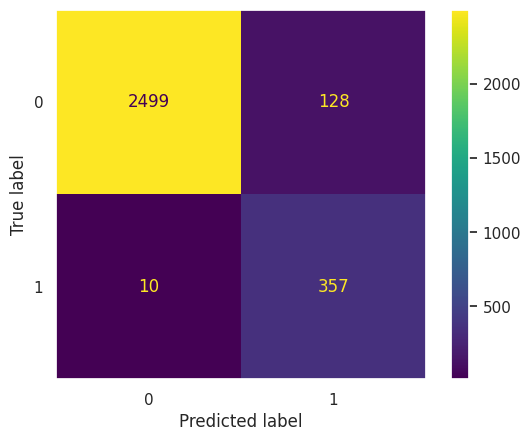

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test)
plt.grid(False)